In [1]:
import numpy as np
from functools import partial
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg 
from typing import Callable

import KF_Library as kf

# Model parameters

In [2]:
l = 10
T = 100*l 
t1 = np.arange(T)
A = np.array([[0.8499, 0.0350, 0.0240, 0.0431],
              [1.2081, 0.0738, 0.0763, 0.4087],
              [0.7331, 0.0674, 0.0878, 0.8767],
              [0.0172, 0.0047, 0.0114, 0.9123]])

B = np.array([[0, 0, 0, 1]])
C = np.array([[1, 0, 0, 0],
              [0, 0, 0, 1]])
Q = np.eye(4)
R = np.eye(2)


nx = np.shape(Q)[0]
ny = np.shape(R)[0]
q = 0.5*np.random.multivariate_normal(np.zeros(nx), Q, T)
r = 0.5*np.random.multivariate_normal(np.zeros(ny), R,  T//l)


# Initialization

In [3]:
x_init = np.array([0., 0., 0., 0.])
cov_init = np.diag([1., 1., 1., 1.])

# Model simulation

In [4]:
x = np.zeros((T,nx))
h = np.zeros((T//l,nx))
y = np.zeros((T//l,ny))
x[0] = x_init
for i in range(1,T):
    x[i] = A @ x[i-1] + q[i-1]
    if i%l == 0:
#         print(x[i-l+1:i+1, :])
        h[i//l ] = 1/l * np.sum(x[i-l+1:i+1, :], axis=0)
        y[i//l ] = C @ h[i//l ] + r[i//l ]


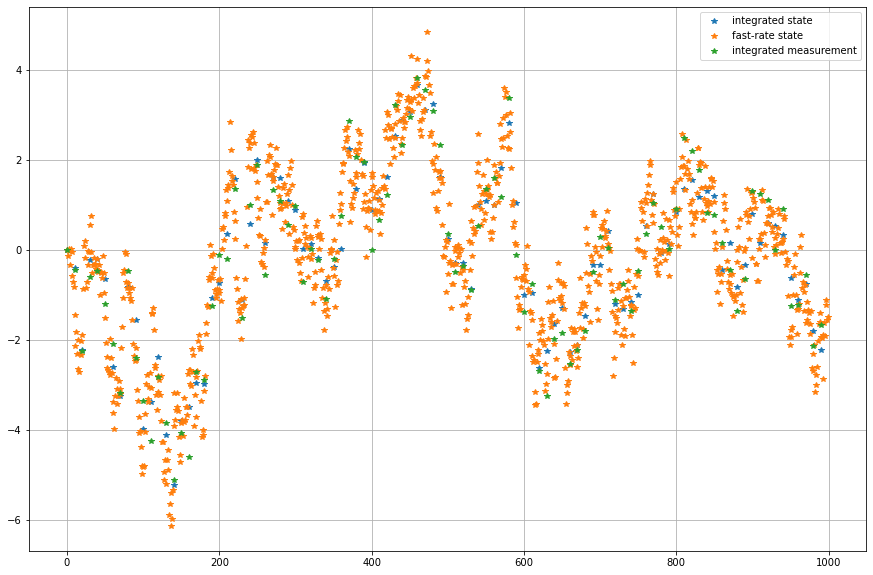

In [5]:
plt.figure(figsize = (15,10))

plt.plot(np.arange(0,T,l),h[:,0],'*',label = 'integrated state')
plt.plot(np.arange(T),x[:,0],'*',label = 'fast-rate state')
plt.plot(np.arange(0,T,l),y[:,0],'*',label = 'integrated measurement')
plt.legend()
plt.grid()

# IMKF

In [6]:
x_hat = np.zeros((T,x_init.shape[0]))
x_hat[0] = x_init
Px = np.zeros((T,x_init.shape[0],x_init.shape[0]))
Px[0] = cov_init
h_hat = np.zeros((T//l,x_init.shape[0]))
Ph = np.zeros((T//l,x_init.shape[0],x_init.shape[0]))

A_bar = 0*A
for i in range(1,l+1):
    A_bar += 1/l * np.linalg.matrix_power(A, i)
M = np.zeros((l,A.shape[0], A.shape[1]))
for i in range(l):
    for j in range(l-i):
        M[i] += 1/l * np.linalg.matrix_power(A, j)
Q_M = 0*Q
for i in range(l):
    Q_M +=  M[i]@Q@M[i].T   

In [7]:
inverse = lambda a: np.linalg.solve(a, np.eye(a.shape[0]))
for t in range(l,T,l):
    
    # prediction
    h_hat_ = A_bar @ x_hat[t-l]
    P_h_   = A_bar @ Px[t-l] @ A_bar.T + Q_M
    
    #Update
    L = P_h_.T @ C.T @ inverse(C @ P_h_ @ C.T + R)
    h_hat[t//l] = h_hat_ + L @ (y[t//l] - C @ h_hat_)
    Ph[t//l] = P_h_ - L @ C @ P_h_

    #Smoothing
    for i in range(1,l+1):
        At = np.linalg.matrix_power(A, i) @ inverse(A_bar)
        x_hat[t-l+i] = At @ h_hat[t//l]
        C_bar = At @ L @ C 
        Qx1 = 0*Q
        Qx2 = 0*Q
        for j in range(1,i+1):
            Qx1 += (C_bar @ M[j-1] - np.linalg.matrix_power(A, i-j)) @ Q @ (C_bar @ M[j-1] - np.linalg.matrix_power(A, i-j)).T
        for j in range(i+1, l+1):
            Qx2 += C_bar @ M[j-1] @ Q @ (C_bar @ M[j-1]).T
        Qx3 = (At - C_bar) @ Q_M @ (At - C_bar).T

        Qx = Qx1 + Qx2 - Qx3
        Px[t-l+i] = At @ Ph[t//l] @ At.T + Qx
        

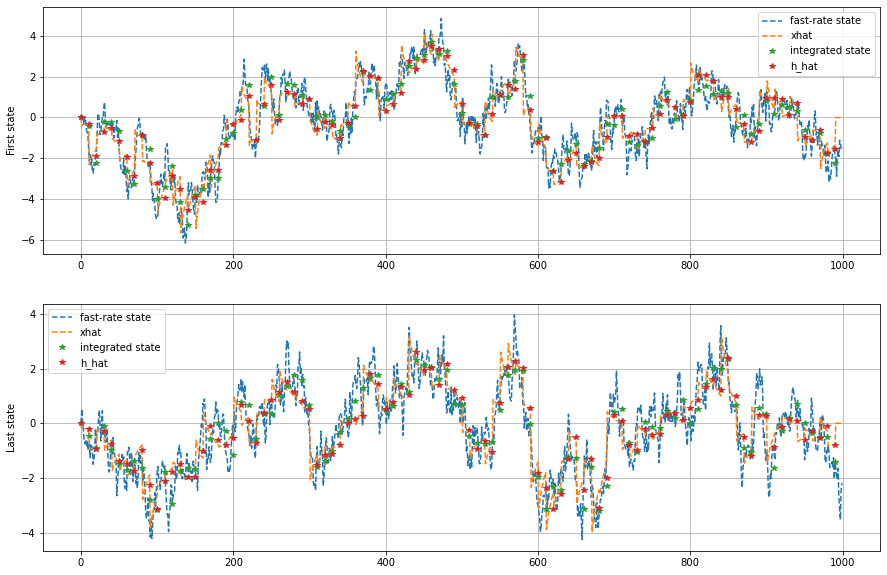

In [8]:
plt.figure(figsize = (15,10))

plt.subplot(211)
plt.plot(x[:,0],'--',label = 'fast-rate state')
plt.plot(x_hat[:,0],'--',label = 'xhat')
plt.plot(np.arange(0,T,l),h[:,0],'*',label = 'integrated state')
plt.plot(np.arange(0,T,l),h_hat[:,0],'*',label = 'h_hat')
plt.ylabel('First state')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(x[:,3],'--',label = 'fast-rate state')
plt.plot(x_hat[:,3],'--',label = 'xhat')
plt.plot(np.arange(0,T,l),h[:,3],'*',label = 'integrated state')
plt.plot(np.arange(0,T,l),h_hat[:,3],'*',label = 'h_hat')
plt.ylabel('Last state')
plt.legend()
plt.grid()

# Parallel integrated state estimation

In [9]:
#filtering
a = kf.filteringInitializer(A_bar, Q_M, C, R, y, x_init, cov_init, T,l)
kf_res = kf.parallelScanAlgorithm(a, T, kf.filtering)

KF_m = []
KF_P = []
for k in range(l,len(kf_res),l): 
    KF_m.append(kf_res[k]['b'])
    KF_P.append(kf_res[k]['C'])
kf_m = np.array(KF_m).reshape(-1,4)

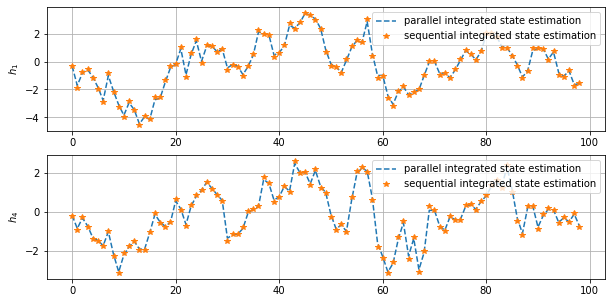

In [10]:

plt.figure(figsize = (10,5))
plt.subplot(211)
plt.plot(kf_m[:,0],'--',label = 'parallel integrated state estimation')
plt.plot(h_hat[1:,0], '*', label = 'sequential integrated state estimation')
plt.ylabel('$h_1$')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(kf_m[:,3],'--',label = 'parallel integrated state estimation')
plt.plot(h_hat[1:,3], '*', label = 'sequential integrated state estimation')
plt.ylabel('$h_4$')
plt.legend()
plt.grid()